In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tabulate import tabulate


In [2]:
#Set parameters
max_val = 1
min_val = -0.2
rest_val = -0.1
decay_val = 0.1
estr_val = 0.4
alpha_val = 0.1
# alpha_val = 0.1
gamma_val = 0.1

#Set number of cycles
ncycles = 100

In [3]:
def pool(n, name, type, nunits, unit_names, projections, weights, extInput=None):
    """
    n: pool number (numeric)
    name: name of pool (e.g., 'hidden') (string)
    type: type of pool (e.g., 'input') (string)
    nunits: number of units in pool (numeric)
    projections: list of pools (list)
    weights: list of weight matrices indexed by pool (list)
    extInput: external input to pool (optional, defaults to None)
    """
    if extInput is None:
        extInput = np.zeros((1, nunits))

    return {"pool_number": n,
        "name": name,
        "type": type, # hidden or input
        "nunits": nunits,
        "unit_names": unit_names,
        "projections": projections,
        "weights": weights,
        "extInput": extInput,
        "activation": np.zeros((1, nunits)),
        "inhibition": np.zeros((1, nunits)),
        "excitation": np.zeros((1, nunits)),
        "netInput": np.zeros((1, nunits)),
        "activation_history": []}


In [4]:
def set_extInput(pool_i, input):
    
    pool_i["extInput"] = np.array([input])
    
    return pool_i

In [5]:
# import data
# Features to Features [14 x 14]
f2F = pd.read_csv("csv_files/NBA_features2features_Small.csv")


f2F.index = f2F.iloc[:, 0]
f2F = f2F.iloc[:, 1:]
f2F_df = f2F.copy()
f2F = np.array(f2F)

features_tuple = tuple(str(idx) for idx in f2F_df.index)

num_features = len(features_tuple)

In [6]:
# features to hidden matrix
f2H = pd.read_csv("csv_files/NBA_features2Hidden_Small.csv", index_col=0)
f2H_df = f2H.copy()
f2H = f2H.fillna(0)
f2H = f2H.to_numpy()

names_tuple = tuple(str(idx) for idx in f2H_df.index)

num_players = len(names_tuple)

In [7]:
def run_simulation(pool_, ncycles):

    for x in range(ncycles):
        print('cycle x:',x)
        for i in range(len(pool_)):
            
            #print('pool i:',i)
            pool_[i]['excitation'] = np.zeros((1, pool_[i]['nunits']))
            pool_[i]['inhibition'] = np.zeros((1, pool_[i]['nunits']))

            for sender in pool_[i]['projections']:
                #print("sender idx:",sender)
                positive_acts_indices = np.argwhere(pool_[sender]['activation'] > 0)[:,1] #np.where(pool_[sender]['activation'] > 0)[0]

                #print("positive activation idx:", positive_acts_indices)

                if len(positive_acts_indices) > 0:
                    for k in range(len(positive_acts_indices)):
                        
                        index = positive_acts_indices[k]
                        #print('specific index:',index)
                        wts = pool_[i]['weights'][sender][index, :]
                        #print('wts = pool_[i][weights][sender][index, :]', wts)
                        #pool_[i]['excitation'][wts > 0] += pool_[sender]['activation'][index] * wts[wts > 0]
                        #pool_[i]['inhibition'][wts < 0] += pool_[sender]['activation'][index] * wts[wts < 0]

                        wts_e=np.argwhere([wts > 0])[:,1]
                        wts_i=np.argwhere([wts < 0])[:,1]

                        #print('wts>0, wts<0',wts_e,wts_i)

                        #print('before:',pool_[i]['excitation'],pool_[i]['inhibition'])

                        for w_e in wts_e: 
                            pool_[i]['excitation'][:,w_e] += pool_[sender]['activation'][:,index] * wts[w_e]                           
                        for w_i in wts_i:
                            pool_[i]['inhibition'][:,w_i] += pool_[sender]['activation'][:,index] * wts[w_i]
                        
                        #print('after:',pool_[i]['excitation'],pool_[i]['inhibition'])
                            

            pool_[i]['excitation'] *= alpha_val
            pool_[i]['inhibition'] *= gamma_val
            #print('after after:',pool_[i]['excitation'],pool_[i]['inhibition'])
            pool_[i]['netInput'] = pool_[i]['excitation'] + pool_[i]['inhibition'] + estr_val * pool_[i]['extInput']

            #print('netinput: ',pool_[i]['netInput'])
        
        for i in range(len(pool_)):

            #print(i)
            pns = np.argwhere(pool_[i]['netInput'] > 0)[:,1]#np.where(pool_[i]['netInput'] > 0)[0]

            if len(pns) > 0:
                for p in pns:
                    pool_[i]['activation'][:,p] += (max_val - pool_[i]['activation'][:,p]) * pool_[i]['netInput'][:,p] - decay_val * (pool_[i]['activation'][:,p] - rest_val)

            nps = np.argwhere(pool_[i]['netInput'] <= 0)[:,1]

            if len(nps) > 0:
                for n in nps:
                    pool_[i]['activation'][:,n] += (pool_[i]['activation'][:,n] - min_val) * pool_[i]['netInput'][:,n] - decay_val * (pool_[i]['activation'][:,n] - rest_val)
            
            pool_[i]['activation'][pool_[i]['activation'] > max_val] = max_val
            pool_[i]['activation'][pool_[i]['activation'] < min_val] = min_val

            pool_[i]['activation_history'].append(np.copy(pool_[i]['activation']))
    
    return pool_

In [8]:
def plot_pools(pool_):

    # pool 1 features
    #a_history_1 = pool_[0]['activation_history']
    a_history_1=np.reshape(np.array(pool_[0]['activation_history']), [ncycles, num_features])
    unit_names_1 = pool_[0]['unit_names']
    m1 = pd.DataFrame(a_history_1)
    m1.columns = unit_names_1
    m1['step']=m1.index
    dfm1=m1.melt('step',var_name='Feature', value_name='Activation')
    plot1=sns.catplot(x="step", y="Activation", hue='Feature', data=dfm1,  kind='point')
    plt.title('Activation of Feature Units by Cycle')
    plt.xlabel('Cycle')
    plt.ylabel('Activation')

    # pool 2 names
    a_history_2 = np.reshape(np.array(pool_[1]['activation_history']), [ncycles, num_players])
    unit_names_2 = pool_[1]['unit_names']
    m2 = pd.DataFrame(a_history_2)
    m2.columns = unit_names_2
    m2['step']=m2.index
    dfm2=m2.melt('step',var_name='Name', value_name='Activation')
    plot2=sns.catplot(x="step", y="Activation", hue='Name', data=dfm2,  kind='point')
    plt.title('Activation of Name Units by Cycle')
    plt.xlabel('Cycle')
    plt.ylabel('Activation')

    # pool 3 - hidden 
    a_history = np.reshape(np.array(pool_[2]['activation_history']), [ncycles, num_players])
    unit_names = pool_[2]['unit_names']
    m3 = pd.DataFrame(a_history)
    m3.columns = unit_names
    m3['step']=m3.index
    dfm3=m3.melt('step',var_name='Hidden Unit', value_name='Activation')
    plot3=sns.catplot(x="step", y="Activation", hue='Hidden Unit', data=dfm3,  kind='point')
    plt.title('Activation of Hidden Units by Cycle')
    plt.xlabel('Cycle')
    plt.ylabel('Activation')

    return {"features": plot1, "names": plot2, "hidden": plot3}


In [9]:
def rank_activations_by_pool(pool_):
    
    features_out = pool_[0]['activation'].flatten()
    features_names = pool_[0]['unit_names']
    features_df = pd.DataFrame({'feature': features_names, 'activation': features_out})
    features_df = features_df.sort_values(by=['activation'], ascending=False)
    
    names_out = pool_[1]['activation'].flatten()
    names_names = pool_[1]['unit_names']
    names_df = pd.DataFrame({'name': names_names, 'activation': names_out})
    names_df = names_df.sort_values(by=['activation'], ascending=False)
    
    hidden_out = pool_[2]['activation'].flatten()
    hidden_names = pool_[2]['unit_names']
    hidden_df = pd.DataFrame({'name': hidden_names, 'activation': hidden_out})
    hidden_df = hidden_df.sort_values(by=['activation'], ascending=False)
    
    return {'features': features_df, 'names': names_df, 'hidden': hidden_df}


In [10]:
# # Features to Features [14 x 14]
# f2F = pd.read_csv("csv_files/NBA_features2features_Small.csv")


# f2F.index = f2F.iloc[:, 0]
# f2F = f2F.iloc[:, 1:]
# f2F_df = f2F.copy()
# f2F = np.array(f2F)

# features_tuple = tuple(str(idx) for idx in f2F_df.index)

# num_features = len(features_tuple)

In [11]:
# # features to hidden matrix
# f2H = pd.read_csv("csv_files/NBA_features2Hidden_Small.csv", index_col=0)
# f2H_df = f2H.copy()
# f2H = f2H.fillna(0)
# f2H = f2H.to_numpy()

# names_tuple = tuple(str(idx) for idx in f2H_df.index)

# num_players = len(names_tuple)


In [12]:
# names to names

n2N = np.full((num_players, num_players), -1)
np.fill_diagonal(n2N, 0)
#n2N

In [13]:
# names to hidden [27 x 27]
# [1] Art Al Sam Clyde Mike Jim Greg John Doug Lance George Pete 
# [13] Fred Gene Ralph Phil Ike Nick Don Ned Karl Ken Earl Rick Ol Neal Dave
n2H = np.eye(num_players)
#n2H

In [14]:
h2H = n2N

In [15]:
featurePool=pool(0, "features", "input", num_features, unit_names = list(features_tuple),projections = list((0,2)), weights = {0 : f2F,2 : f2H})


In [16]:
namePool=pool(1, "names", "input", num_players, unit_names = list(names_tuple),projections = list((1,2)), weights = {1 : n2N,2 : n2H})

In [17]:
hiddenPool=pool(2, "hidden", "hidden", num_players, unit_names = list(names_tuple),projections = list((0,1,2)), weights = {0:f2H.T, 1:n2H.T, 2:h2H})

In [18]:
# js = pd.read_csv('jetsSharks.csv', header=None)
# js = pd.read_csv('nba_players_small.csv', header=None)
js = pd.read_csv('csv_files/nba_players_small.csv')
# js.columns = ["Name", "Affiliation", "Age", "Education", "Relationship Status", "Occupation"]
print(tabulate(js, headers='keys', tablefmt='psql'))

+----+-------------------------+------------+--------------+-------+---------+---------------+--------------+
|    | Name                    | Position   | Height       | Age   | Draft   | Nationality   | Conference   |
|----+-------------------------+------------+--------------+-------+---------+---------------+--------------|
|  0 | Bam Adebayo             | Center     | 6'5" - 6'11" | 25-29 | Round 1 | Domestic      | Eastern      |
|  1 | Giannis Antetokounmpo   | Forward    | 6'5" - 6'11" | 25-29 | Round 1 | International | Eastern      |
|  2 | Jaylen Brown            | Forward    | 6'5" - 6'11" | 25-29 | Round 1 | Domestic      | Eastern      |
|  3 | Stephen Curry           | Guard      | 6' - 6'5"    | 35+   | Round 1 | Domestic      | Western      |
|  4 | DeMar DeRozan           | Guard      | 6'5" - 6'11" | 30-34 | Round 1 | Domestic      | Eastern      |
|  5 | Luka Doncic             | Forward    | 6'5" - 6'11" | 18-24 | Round 1 | International | Western      |
|  6 | Kev

In [19]:
# featurePool=set_extInput(featurePool, np.array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]))

# Guard, 6_5 to 6_11
featurePool=set_extInput(featurePool, np.array([0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))

namePool=set_extInput(namePool, np.zeros(num_players))

In [20]:
pool_= list((featurePool, namePool, hiddenPool))
#pool_[0]

In [21]:

pool_=run_simulation(pool_,ncycles)

cycle x: 0
cycle x: 1
cycle x: 2
cycle x: 3
cycle x: 4
cycle x: 5
cycle x: 6
cycle x: 7
cycle x: 8
cycle x: 9
cycle x: 10
cycle x: 11
cycle x: 12
cycle x: 13
cycle x: 14
cycle x: 15
cycle x: 16
cycle x: 17
cycle x: 18
cycle x: 19
cycle x: 20
cycle x: 21
cycle x: 22
cycle x: 23
cycle x: 24
cycle x: 25
cycle x: 26
cycle x: 27
cycle x: 28
cycle x: 29
cycle x: 30
cycle x: 31
cycle x: 32
cycle x: 33
cycle x: 34
cycle x: 35
cycle x: 36
cycle x: 37
cycle x: 38
cycle x: 39
cycle x: 40
cycle x: 41
cycle x: 42
cycle x: 43
cycle x: 44
cycle x: 45
cycle x: 46
cycle x: 47
cycle x: 48
cycle x: 49
cycle x: 50
cycle x: 51
cycle x: 52
cycle x: 53
cycle x: 54
cycle x: 55
cycle x: 56
cycle x: 57
cycle x: 58
cycle x: 59
cycle x: 60
cycle x: 61
cycle x: 62
cycle x: 63
cycle x: 64
cycle x: 65
cycle x: 66
cycle x: 67
cycle x: 68
cycle x: 69
cycle x: 70
cycle x: 71
cycle x: 72
cycle x: 73
cycle x: 74
cycle x: 75
cycle x: 76
cycle x: 77
cycle x: 78
cycle x: 79
cycle x: 80
cycle x: 81
cycle x: 82
cycle x: 83
cy

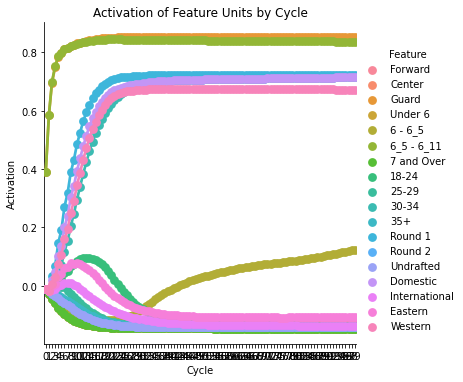

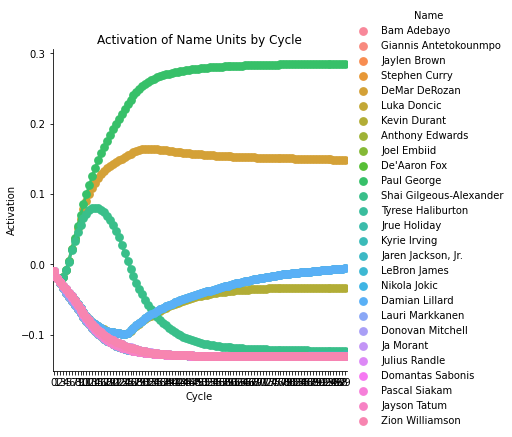

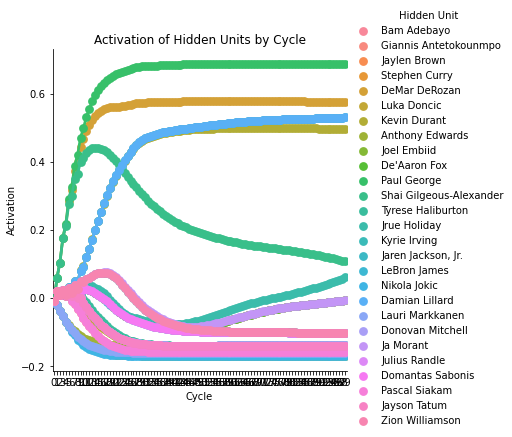

In [22]:
nnplot = plot_pools(pool_)
#nnplot.hidden

In [23]:
ranked_activations = rank_activations_by_pool(pool_)

# Display the 'hidden' pool in a table
hidden_table = ranked_activations['hidden']
hidden_table = hidden_table.reset_index(drop=True)  # Reset index to start from 0
hidden_table.insert(0, 'Rank', range(1, len(hidden_table) + 1))  # Add rank column
hidden_table_html = tabulate(hidden_table, headers='keys')  # Convert to HTML table

# Print the HTML table
print(hidden_table_html)

      Rank  name                       activation
--  ------  -----------------------  ------------
 0       1  Paul George                0.686219
 1       2  DeMar DeRozan              0.574792
 2       3  Damian Lillard             0.530257
 3       4  Kyrie Irving               0.530257
 4       5  Kevin Durant               0.495334
 5       6  Shai Gilgeous-Alexander    0.108046
 6       7  Jrue Holiday               0.0607083
 7       8  Ja Morant                 -0.0065609
 8       9  De'Aaron Fox              -0.00658353
 9      10  Stephen Curry             -0.00658356
10      11  Jaren Jackson, Jr.        -0.10256
11      12  Zion Williamson           -0.10256
12      13  Domantas Sabonis          -0.102589
13      14  LeBron James              -0.102589
14      15  Tyrese Haliburton         -0.136591
15      16  Donovan Mitchell          -0.136591
16      17  Jaylen Brown              -0.141284
17      18  Julius Randle             -0.141284
18      19  Jayson Tatum        

In [24]:
names_table = ranked_activations['names']
names_table = names_table.reset_index(drop=True)  # Reset index to start from 0
names_table.insert(0, 'Rank', range(1, len(names_table) + 1))  # Add rank column
names_table_html = tabulate(names_table, headers='keys')  # Convert to HTML table

# Print the HTML table
print(names_table_html)

# ranked_activations

      Rank  name                       activation
--  ------  -----------------------  ------------
 0       1  Paul George                 0.284635
 1       2  DeMar DeRozan               0.14832
 2       3  Damian Lillard             -0.0058845
 3       4  Kyrie Irving               -0.0058845
 4       5  Kevin Durant               -0.0342735
 5       6  Shai Gilgeous-Alexander    -0.123749
 6       7  Jrue Holiday               -0.128224
 7       8  Ja Morant                  -0.130244
 8       9  Jaren Jackson, Jr.         -0.130244
 9      10  Zion Williamson            -0.130244
10      11  Domantas Sabonis           -0.130244
11      12  LeBron James               -0.130244
12      13  De'Aaron Fox               -0.130244
13      14  Stephen Curry              -0.130244
14      15  Tyrese Haliburton          -0.130244
15      16  Jaylen Brown               -0.130244
16      17  Julius Randle              -0.130244
17      18  Jayson Tatum               -0.130244
18      19  Bam 

In [25]:
# Display the 'hidden' pool in a table
feature_table = ranked_activations['features']
#feature_table = feature_table.reset_index(drop=True)  # Reset index to start from 0
#feature_table.insert(0, 'Rank', range(1, len(feature_table) + 1))  # Add rank column
#feature_table_html = tabulate(feature_table, headers='keys')  # Convert to HTML table

#Print feature table
print(feature_table)

          feature  activation
2           Guard    0.853101
5      6_5 - 6_11    0.836984
11        Round 1    0.723781
9           30-34    0.715682
14       Domestic    0.715682
17        Western    0.672158
4         6 - 6_5    0.124099
16        Eastern   -0.105765
0         Forward   -0.126248
7           18-24   -0.137284
15  International   -0.137284
8           25-29   -0.141671
10            35+   -0.141671
12        Round 2   -0.141972
13      Undrafted   -0.141972
1          Center   -0.146032
6      7 and Over   -0.148723
3         Under 6   -0.148723


In [26]:
feature_table

,feature,activation
2,Guard,0.853101
5,6_5 - 6_11,0.836984
11,Round 1,0.723781
9,30-34,0.715682
14,Domestic,0.715682
17,Western,0.672158
4,6 - 6_5,0.124099
16,Eastern,-0.105765
0,Forward,-0.126248
7,18-24,-0.137284


In [27]:
# x = (np.asarray(feature_table['feature']))
# y = (np.asarray(feature_table['activation']))
# size = [int((abs(n))*500) for n in (y)]


# #gang
# camp_options = ['Jets', 'Sharks']
# camp = feature_table[feature_table['feature'].isin(camp_options)]
# camp_x = (np.asarray(camp['feature']))
# camp_y = (np.asarray(camp['activation']))
# camp_size = [int((abs(n))*500) for n in (camp_y)]

# #age
# age_options = ['20s', '30s', '40s']
# age = feature_table[feature_table['feature'].isin(age_options)]
# age_x = (np.asarray(age['feature']))
# age_y = (np.asarray(age['activation']))
# age_size = [int((abs(n))*500) for n in (age_y)]

# #marital status
# mar_options = ['Single', 'Married', 'Divorced']
# mar = feature_table[feature_table['feature'].isin(mar_options)]
# mar_x = (np.asarray(mar['feature']))
# mar_y = (np.asarray(mar['activation']))
# mar_size = [int((abs(n))*500) for n in (mar_y)]

# #education
# edu_options = ['JH', 'HS', 'COL']
# edu = feature_table[feature_table['feature'].isin(edu_options)]
# edu_x = (np.asarray(edu['feature']))
# edu_y = (np.asarray(edu['activation']))
# edu_size = [int((abs(n))*500) for n in (edu_y)]

# #occupation
# occ_options = ['Burglar', 'Pusher', 'Bookie']
# occ = feature_table[feature_table['feature'].isin(occ_options)]
# occ_x = (np.asarray(occ['feature']))
# occ_y = (np.asarray(occ['activation']))
# occ_size = [int((abs(n))*500) for n in (occ_y)]

# plt.style.use('seaborn')
# plt.scatter(x, y, c=y, s=size, vmin=-1, vmax=1, cmap='rainbow')
# plt.xticks(rotation = 45)
# plt.axhline(0, c='black', ls='--')
# plt.xlabel("Features")  
# plt.ylabel("Activation Values")
# plt.colorbar()

In [28]:
# fig = plt.figure()
# plt.style.use('seaborn')
# fig, axs = plt.subplots(2, 3)
# axs[0, 0].scatter(camp_x, camp_y, c=camp_y, s=camp_size, vmin=-1, vmax=1, cmap='rainbow')
# axs[0, 0].set_title('Gang')
# axs[0, 0].axhline(0, c='black', ls='--')

# axs[0, 1].scatter(age_x, age_y, c=age_y, s=age_size, vmin=-1, vmax=1, cmap='rainbow')
# axs[0, 1].set_title('Age')
# axs[0, 1].axhline(0, c='black', ls='--')

# axs[0, 2].scatter(mar_x, mar_y, c=mar_y, s=mar_size, vmin=-1, vmax=1, cmap='rainbow')
# axs[0, 2].set_title('Marital Status')
# axs[0, 2].axhline(0, c='black', ls='--')

# axs[1, 0].scatter(edu_x, edu_y, c=edu_y, s=edu_size, vmin=-1, vmax=1, cmap='rainbow')
# axs[1, 0].set_title('Education')
# axs[1, 0].axhline(0, c='black', ls='--')

# axs[1, 1].scatter(occ_x, occ_y, c=occ_y, s=occ_size, vmin=-1, vmax=1, cmap='rainbow')
# axs[1, 1].set_title('Occupation')
# axs[1, 1].axhline(0, c='black', ls='--')

# fig.tight_layout(pad=3.0)   
# plt.show()
